In [5]:
import sys
sys.path.append('../')
import numpy as np
from source.reader import read_raw
import matplotlib.pyplot as plt
%matplotlib notebook

In [7]:
# Data import
file_name = "../data/fid_large.h5"
data, index, metadata = read_raw(file_name)
num_channels_all = metadata['console']['adc']['number_channels']
num_channels_signal = metadata['rf']['receive']['num_signal_channels']
idx_chan_sig = slice(num_channels_signal)
idx_chan_ref = slice(num_channels_signal, num_channels_all)

In [8]:
# Correction
spec_scan = np.fft.fftshift(np.fft.fft(data['scan'], axis=-1), axes=-1)
spec_prescan = np.fft.fftshift(np.fft.fft(data['noise'], axis=-1), axes=-1)
n_freq_bins = spec_scan.shape[2]
spec_cor = np.zeros([spec_scan.shape[0], num_channels_signal, n_freq_bins], dtype=np.complex64)
coeff_all = np.zeros((num_channels_signal, num_channels_all - num_channels_signal, n_freq_bins), dtype=np.complex64)
for _f in range(n_freq_bins):
    # compute coefficients from prescan
    prescan_sig = spec_prescan[:, idx_chan_sig, _f]
    prescan_ref = spec_prescan[:, idx_chan_ref, _f]
    coeff = np.linalg.lstsq(prescan_ref, prescan_sig, rcond=-1)[0]
    coeff_all[:, :, _f] = coeff
    # apply correction
    scan_sig = spec_scan[:, idx_chan_sig, _f]
    scan_ref = spec_scan[:, idx_chan_ref, _f]
    spec_cor[:, :, _f] = scan_sig - np.dot(scan_ref, coeff)

(1, 8, 200)


<IPython.core.display.Javascript object>


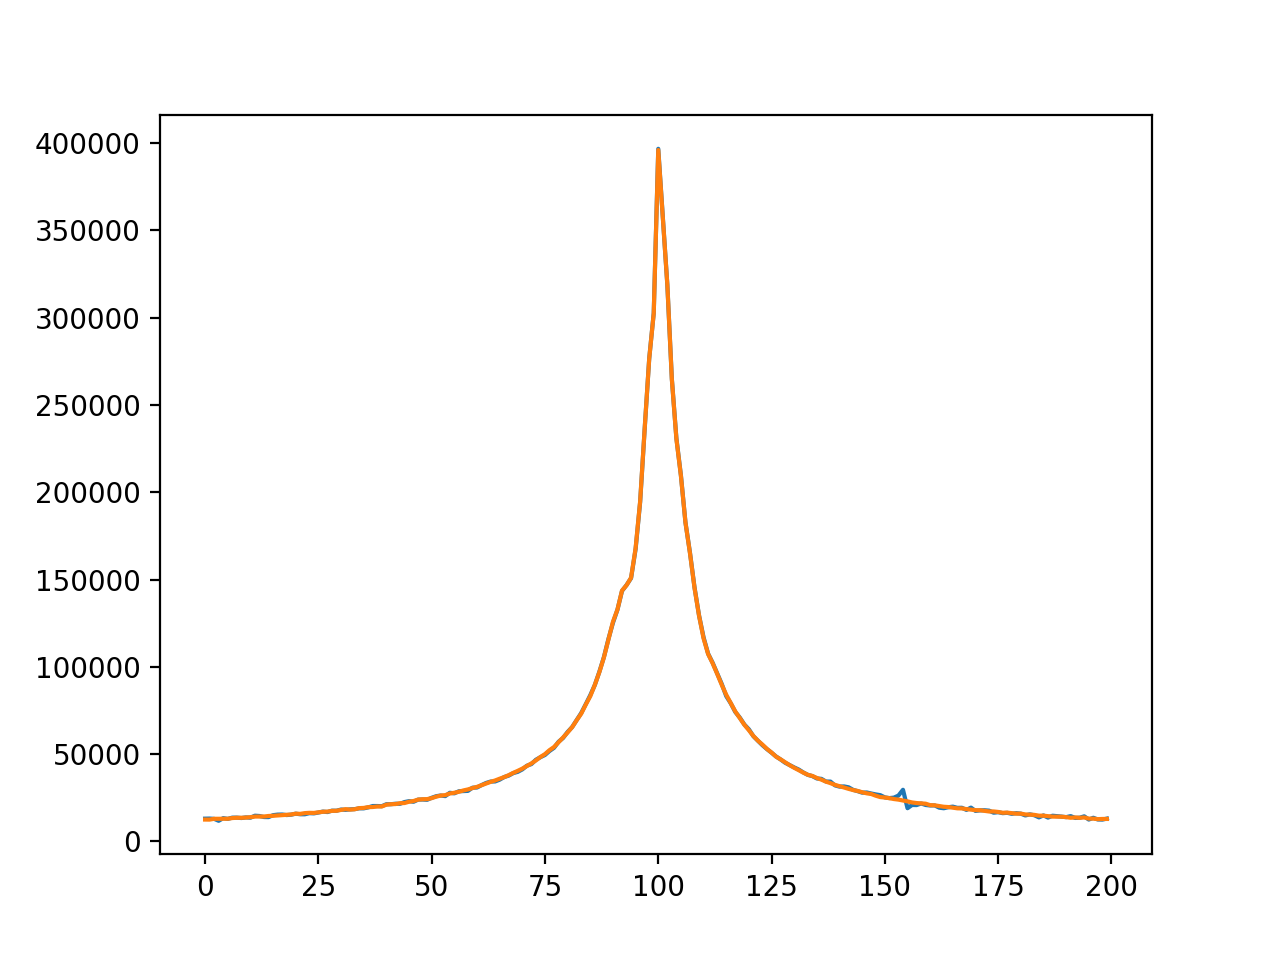

In [9]:
print(spec_cor.shape)
ch = 0
plt.figure()
plt.plot(np.abs(spec_scan[-1, ch, :]))
plt.plot(np.abs(spec_cor[-1, ch, :]))
plt.show()

<IPython.core.display.Javascript object>


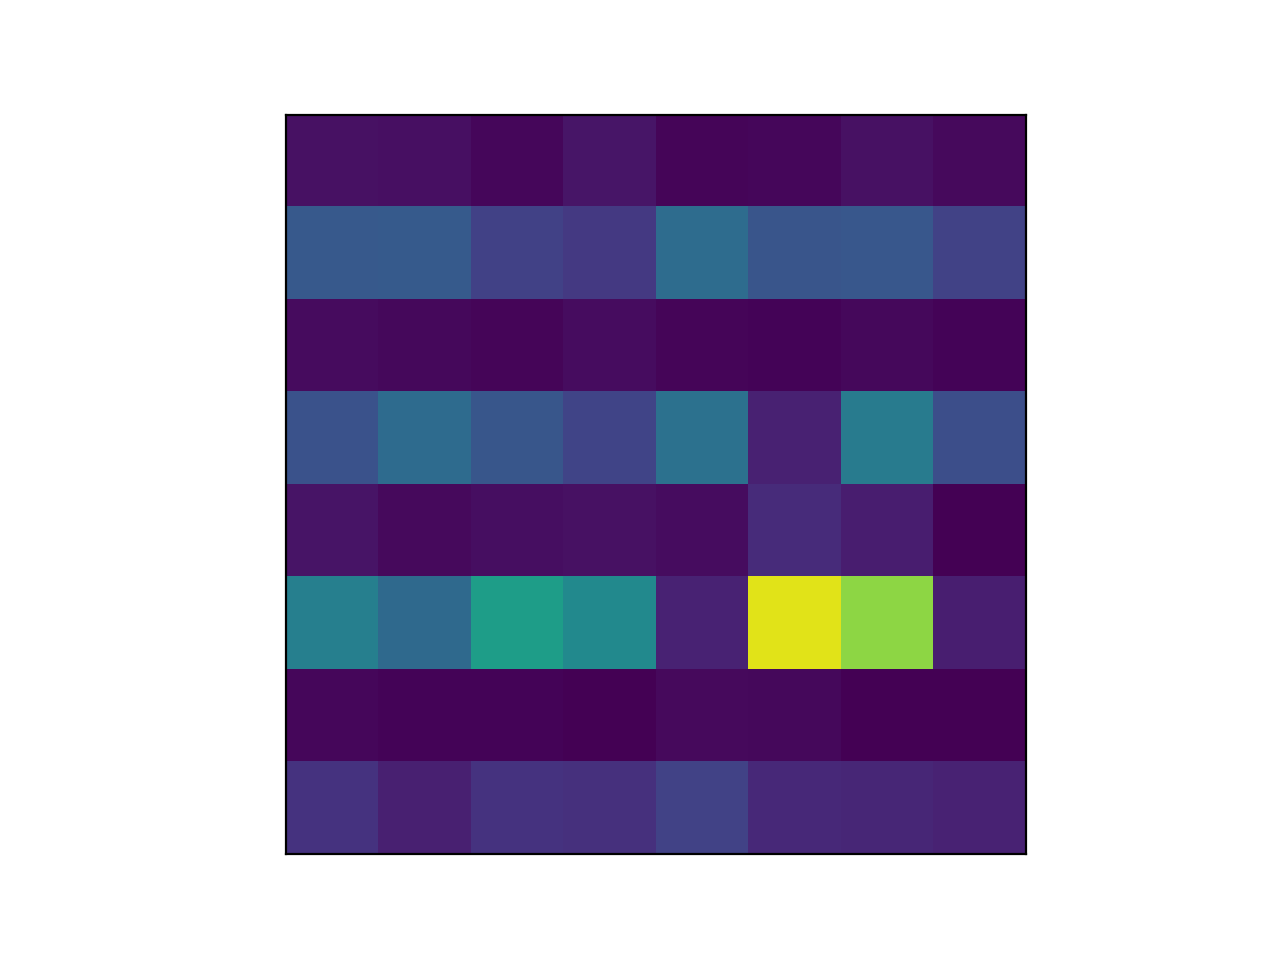

In [5]:
# Display coefficients
from matplotlib.animation import FuncAnimation
fig = plt.figure()
plt.xticks([])
plt.yticks([])
a=np.abs(coeff_all[:, :, 0])
im=plt.imshow(a,interpolation='none')

def init():
    im.set_data(np.abs(coeff_all[:, :, 0]))
    return im

# animation function.  This is called sequentially
def animate(i):
    im.set_array(np.abs(coeff_all[:, :, i]))
    return im

ani = FuncAnimation(fig, animate, frames=np.arange(142), interval=20, repeat=True,
                    init_func=init, blit=True)
plt.show()

/Users/had-mr/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<IPython.core.display.Javascript object>


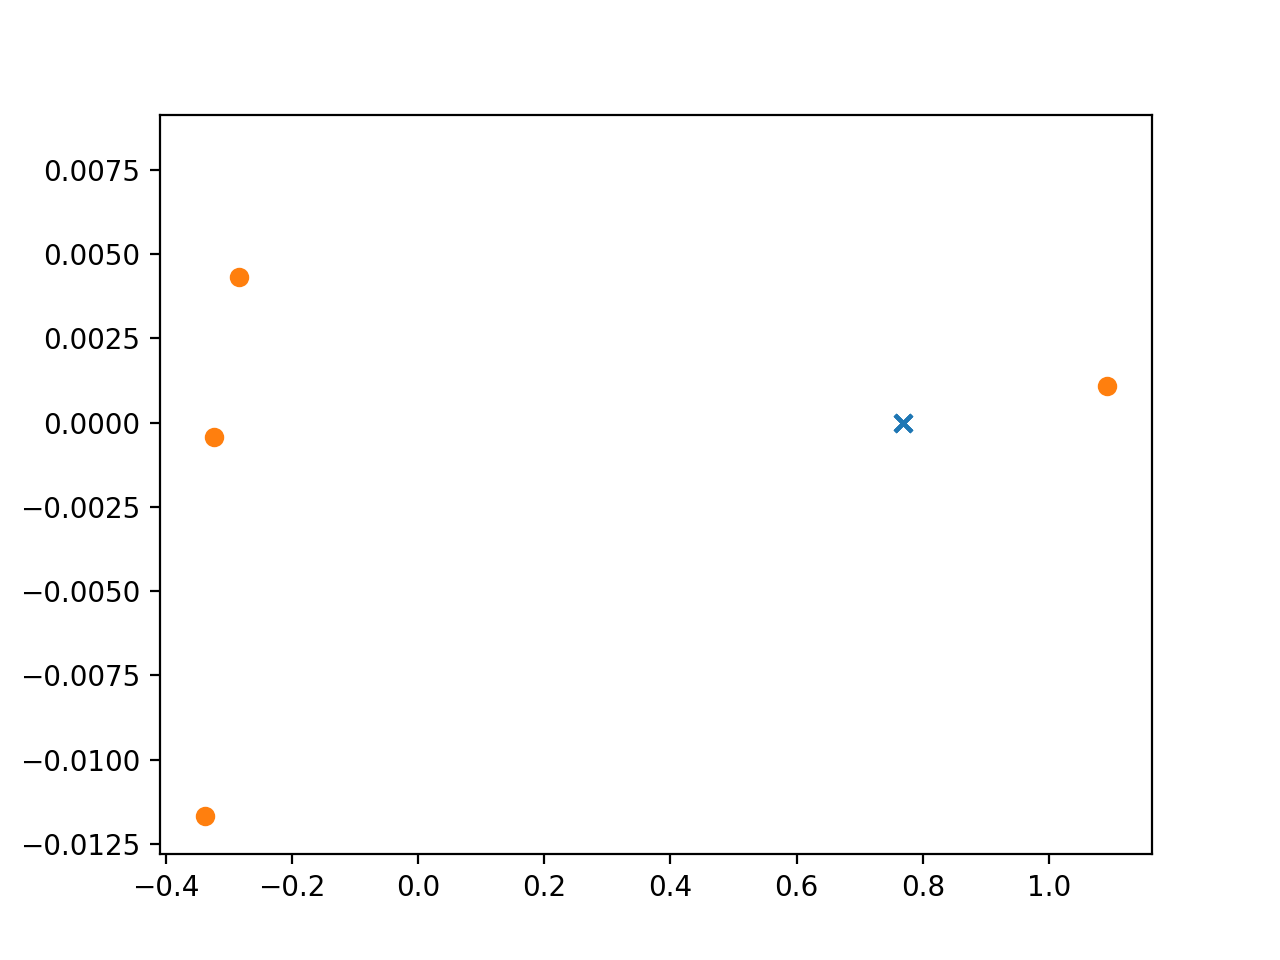

0.05036329597250216
0.06271578072019401


<IPython.core.display.Javascript object>


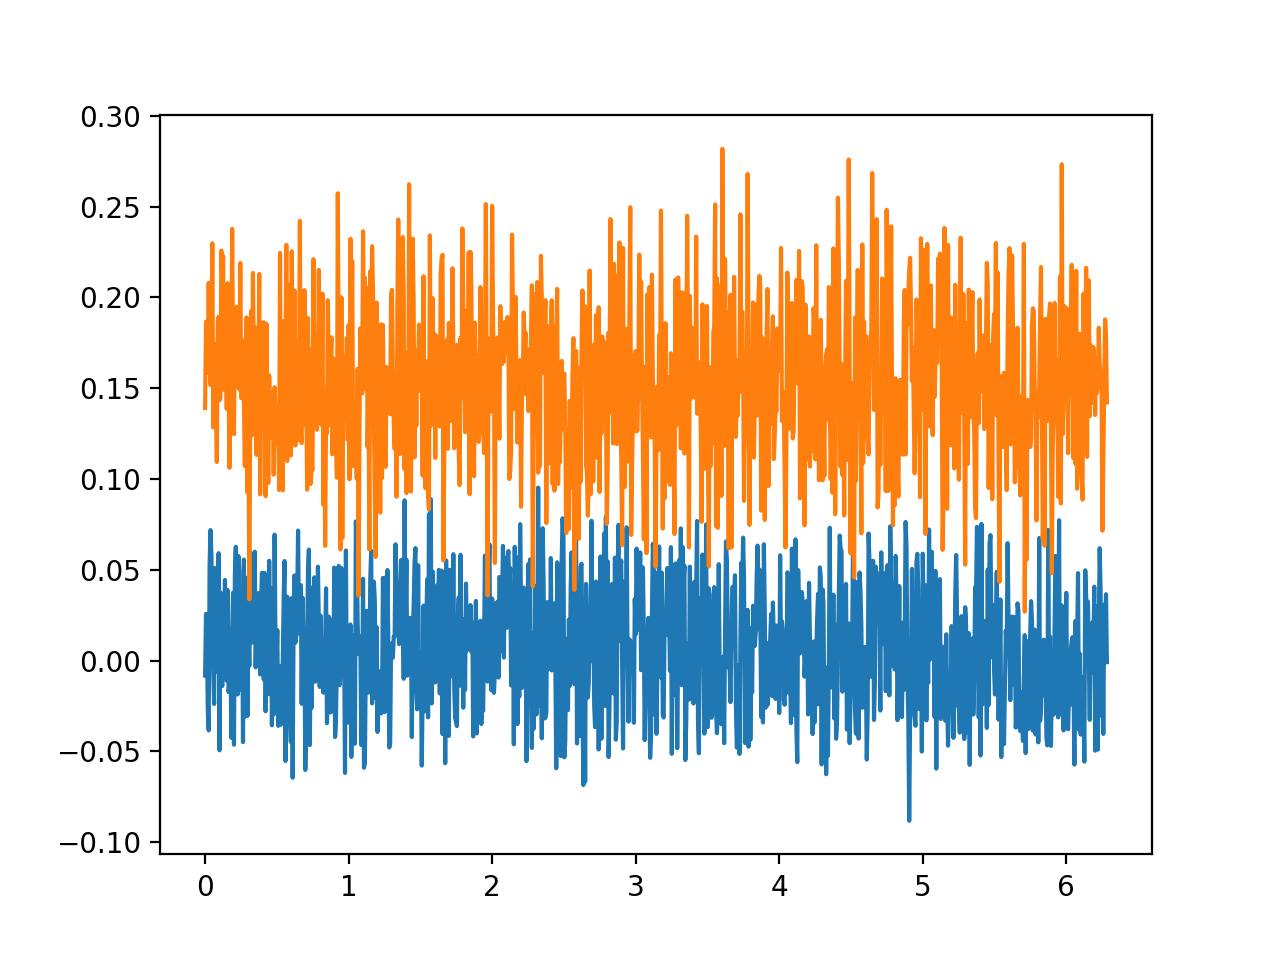

In [289]:
# Testing the coefficient fitting
tt = np.linspace(0, 2*np.pi, 1000)
s = np.exp(1j * 10 * tt)
c = np.array([0.1*np.exp(1j*np.pi*0), 0.1*np.exp(1j*np.pi*0), 0.1*np.exp(1j*np.pi*0), 1*np.exp(1j*np.pi*0)])
c = c[:, np.newaxis].T
r = c.T * s
s += 0.1 * np.random.random(s.shape)
n = np.random.random(r.shape) + 1j* np.random.random(r.shape)
r += 0.1*n

c_est = np.linalg.lstsq(r.T, s.T)[0]
s_est = np.dot(c_est, r)

c_inv = np.exp(-1j*np.angle(c)) / np.sum(np.abs(c))
s_inv = np.squeeze(np.dot(c_inv, r))

plt.figure()
plt.scatter(np.real(c_inv), np.imag(c), marker='x')
plt.scatter(np.real(c_est), np.imag(c_est), marker='o')
plt.show()
print(np.std(s_est - s))
print(np.std(s_inv - s))
plt.figure()
# plt.plot(tt, np.real(s))
plt.plot(tt, np.real(s_est-s))
plt.plot(tt, np.real(s_inv-s))
plt.show()
